In [1]:
##installs pytorch on a cuda-capable windows machine using pip

%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

%pip install torchsummary

%pip install numpy

%pip install matplotlib

%pip install opencv-python

%pip install scikit-learn

%pip install pandas

%pip install tqdm

%pip install pickle5

%pip install git+https://github.com/albumentations-team/albumentations

SyntaxError: invalid syntax (1784681406.py, line 21)

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

In [3]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [4]:
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [5]:
target_dir="plain-augmentation"

In [6]:
if(os.path.split(os.getcwd())[1] == target_dir):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = False

Current Working Directory: progettoVIPM


In [7]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset

In [8]:
from utils.extractNeuralFeatures import extract_features

In [9]:
chosen_net = networks.ALEXNET
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))

Original classification layers:Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [10]:
random.seed(42)
train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),        
        A.RandomToneCurve(scale=0.7, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#as required by All pre-trained models of torch
        ToTensorV2(),
    ]
)


In [11]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu

linear_layers_to_remove = 3
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers = extract_features(augmented=True, train_set=datasets.TRAINING_LABELED,
                                                                                            test_set=datasets.TEST,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda, 
                                                                                            transform=train_transform)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 5020
Feature vector shape of Train: (5020, 9216)
Label vector shape of Train: (5020,)
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 11994
Feature vector shape of Test: (11994, 9216)
Label vector shape of Test: (11994,)
---------------------------------------------------------------------------------
Original classification layers:Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
-------------------------------------

In [12]:

from torch.utils.data import DataLoader
from copy import deepcopy

fine_tune_layers[-1].out_features = 251
print(fine_tune_layers[:])
model = deepcopy(fine_tune_layers)

loss_function = torch.nn.CrossEntropyLoss()
if (cuda):
    y_test = torch.tensor(y_test).type(torch.LongTensor).cuda()
else:
    y_test = torch.tensor(y_test).type(torch.LongTensor)
    X_test_ale_t = torch.from_numpy(X_test_ale_n).float()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

test_loader = DataLoader(torch.utils.data.TensorDataset(X_test_ale_t, y_test), batch_size=1, shuffle=False)



Sequential(
  (0): Linear(in_features=9216, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=4096, out_features=251, bias=True)
)


In [13]:
def train_one_epoch(epoch_index, tb_writer, training_loader, model, loss_function, optimizer):
    running_loss = 0.
    avg_batch_loss = 0.
    n_batch = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_function(outputs, labels)
        avg_batch_loss += loss.item()
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        # running_loss += loss.item()
        # if i % 10 == 9:
        #     last_loss = running_loss / 10 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(training_loader) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.
        n_batch += 1

    return avg_batch_loss/n_batch

In [14]:
from datetime import datetime
from tensorboardX import SummaryWriter
from IPython.display import clear_output

def train_model(n_epochs, model, loss_function, optimizer):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    epoch_number = 0 
    best_vloss = 1_000_000.
    losses = np.empty((n_epochs,2))

    for epoch in range(n_epochs):
        clear_output(wait=True)
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)


        ###### construct a new training_loader and validation_loader from the original non-modified data; this is necessary because using the same loaders in different epochs means using the same images, not creating new versions of the originals
        linear_layers_to_remove = 3
        X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers = extract_features(target_dir="plain-augmentation", train_set=datasets.TRAINING_LABELED,
                                                                                                    test_set=datasets.TEST,
                                                                                                    network=chosen_net,
                                                                                                    layers_to_remove=linear_layers_to_remove, 
                                                                                                    cuda=cuda, 
                                                                                                    transform=train_transform)
        if (cuda):
            y_train = torch.tensor(y_train).type(torch.LongTensor).cuda()
            y_test = torch.tensor(y_test).type(torch.LongTensor).cuda()
        else:
            y_train = torch.tensor(y_train).type(torch.LongTensor)
            y_test = torch.tensor(y_test).type(torch.LongTensor)
            X_train_ale_t = torch.from_numpy(X_train_ale_n).float()

        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        dataset_train = torch.utils.data.TensorDataset(X_train_ale_t, y_train)
        train_dataset, val_dataset = torch.utils.data.random_split(dataset_train, [0.9, 0.1])
        training_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
        validation_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
        ######
        avg_loss = train_one_epoch(epoch_number, writer, training_loader, model, loss_function, optimizer)


        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_function(voutputs, vlabels)
                running_vloss += vloss.item()

        avg_vloss = running_vloss / (i + 1)
        losses[epoch_number] = [avg_loss, avg_vloss]
        print('LOSS: train {}; valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        # if avg_vloss < best_vloss:
        #     best_vloss = avg_vloss
        #     model_path = './Transfer_Learning/models/neural/model_{}_{}'.format(timestamp, epoch_number)
        #     torch.save(model.state_dict(), model_path)

        epoch_number += 1
    return model, losses

In [15]:

trained_model, losses = train_model(n_epochs=100, 
                                    model=model, loss_function=loss_function, optimizer=optimizer)

EPOCH 100:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 5020
Feature vector shape of Train: (5020, 9216)
Label vector shape of Train: (5020,)
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 11994
Feature vector shape of Test: (11994, 9216)
Label vector shape of Test: (11994,)
---------------------------------------------------------------------------------
LOSS: train 5.545663754145305; valid 5.574054479598999


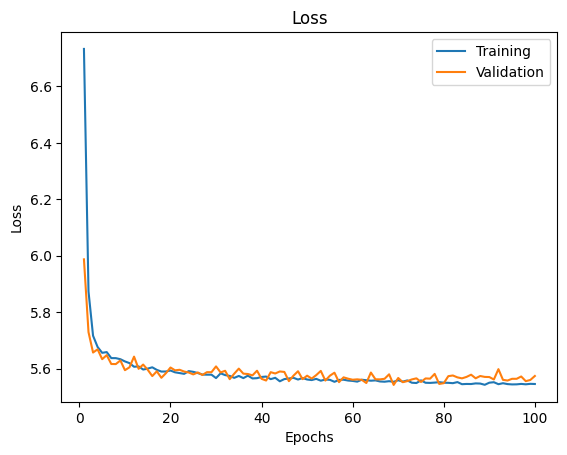

In [16]:
def plot_loss(history):
  x_plot = list(range(1,len(history)+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history[:,0])
  plt.plot(x_plot, history[:,1])
  plt.legend(['Training', 'Validation'])

# print(losses)
plot_loss(losses)

In [19]:
trained_model.eval()

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
predictions = np.zeros(len(test_loader))
# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    i = 0
    for test_data in tqdm(test_loader):
        test_features, test_labels = test_data
        predictions[i] = np.argmax(np.array(trained_model(test_features).cpu()))
        i+=1
y_test = np.array(y_test.cpu())
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {}".format(accuracy))
        

Accuracy: 0.003501750875437719
